In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import types
from yahoo_fin.stock_info import *
import pandas_datareader.data as pdr
import yfinance as yf
from BackTestAlgo import *
from Order import *
from DataQuery import *
from Record import *
from AlphaBeta import *
from Preprocessing import *

In [2]:
def my_init(context):
    data = pd.read_csv('C:/Users/ajcltm/PycharmProjects/BackTesting/data/stock_price_data_KOSPI.csv')
    tickers = data['symbol'].unique().tolist()
    context.symbols = tickers
    # universe를 symbols로 정의(반드시 지정해야함)

    context.price = 'Adj Close'
    # price로 사용할 칼럼 인덱스 이름을 알려줘야함(open, high, close 등의 인덱스를 price로 활용 가능함)
    # 여기서 지정한 인덱스는 포트폴리오를 평가할 때 기본적으로 사용하는 지표임

    context.capital_base = 50000000
    # 투자원금을 설정함. 지정하지 않으면 기본값을 사용함

    # context.market_benchmark = 'SP500'
    # 지정하면 win_rate 계산 시에 비교, 지정 안하면 절대수익(0%와 비교)으로 계산

    context.i = 0

In [3]:
def handle_data(context, data):
    context.i += 1
    print('\n')
    print(data.current_time)

    if context.i == 1:
        p1 = pd.read_csv('C:/Users/ajcltm/Desktop/p1.csv', index_col=0)
        tickers = p1.tickers.apply(lambda x: '{:06d}'.format(x))
        print(len(tickers))
        s = {'ticker': [], 'price': []}
        f = {'ticker': [], 'price': []}
        for ticker in tickers:
            try:
                price = data.current_data('{}.KS'.format(ticker), 'Adj Close')
                s['ticker'].append('{}.KS'.format(ticker))
                s['price'].append(price)
            except:
                f['ticker'].append(ticker)
                f['price'].append(0)
        quantity = list(map(lambda x: int((50000000/len(s['price'])) / x), s['price']))
        print(len(s['price']))
        print(s['price'])
        print(quantity)
        print(np.dot(np.array(s['price']), np.array(quantity)))
        order(context, s['ticker'], s['price'], quantity)


    bench_return = context.benchmark['benchmark_class'].benchmark_history(context, context.benchmark['benchmark_symbols'], 'return', 1).values[0]

    record(context, bench_return=bench_return)

In [4]:
data = pd.read_csv('C:/Users/ajcltm/PycharmProjects/BackTesting/data/stock_price_data_KOSPI_fixed.csv')
data = data.reset_index(drop=True)
data = data.sort_values(by='date')
data['date'] = pd.to_datetime(data['date'])
data = data.loc[data['date'] > datetime.datetime(2020, 5, 24)]

yf.pdr_override()

start_date = '25-05-2020'
end_date = '18-07-2021'

start = datetime.datetime.strptime(start_date, '%d-%m-%Y')
end = datetime.datetime.strptime(end_date, '%d-%m-%Y')

temp_data = pdr.get_data_yahoo('^KS11', data_source='yahoo', start=start, end=end)

temp_data['date'] = temp_data.index
temp_data = temp_data.reset_index(drop=True)
temp_data = temp_data.rename(columns={'Adj Close': 'price'})
temp_data['benchmark'] = 'kospi_200'
benchmark = temp_data

tester = BackTester(initialize=my_init, tradingAlgo=handle_data)

result = tester.run(data, benchmark)

pd.set_option('display.max.columns', 50)
pd.set_option('display.max_rows', 1000)

[*********************100%***********************]  1 of 1 completed

Hello backtesting


2020-05-25 00:00:00
119
118
[4040.0, 16050.0, 10200.0, 13100.0, 80600.0, 11000.0, 50300.0, 4780.0, 15000.0, 7280.0, 10150.0, 7020.0, 23300.0, 42900.0, 4260.0, 9310.0, 53400.0, 18000.0, 5249.91015625, 44050.0, 80800.0, 25300.0, 59500.0, 29200.0, 26500.0, 83300.0, 10050.0, 126000.0, 60800.0, 23250.0, 49400.0, 6790.0, 31850.0, 31100.0, 14350.0, 3395.0, 2520.0, 36400.0, 41800.0, 55800.0, 18700.0, 67100.0, 9100.0, 7620.0, 32350.0, 20400.0, 3980.0, 17000.0, 4970.0, 2860.0, 20100.0, 9000.0, 67700.0, 3950.0, 57600.0, 9490.0, 3660.0, 6830.0, 11600.0, 1870.0, 5500.0, 13050.0, 21500.0, 47550.0, 17600.0, 3090.0, 64682.8984375, 37600.0, 3450.0, 7430.0, 10750.0, 27900.0, 17350.0, 9710.0, 79900.0, 59700.0, 9350.0, 15650.0, 19100.0, 16900.0, 37900.0, 69439.296875, 15500.0, 3280.0, 14650.0, 2720.0, 172000.0, 2120.0, 1500.0, 4350.0, 3095.0, 1690.0, 1685.0, 40900.0, 3990.0, 135500.0, 4780.0, 36800.0, 211500.0, 9090.

0 0
0.0
0.0
0 0
periods : 1


2020-05-26 00:00:00
periods : 1


C:\Users\ajcltm\PycharmProjects\BackTesting\BackTestAlgo.py:181: RuntimeWarning: invalid value encountered in double_scalars
  sharp_ratio = annualized_return / std_y
C:\Users\ajcltm\PycharmProjects\BackTesting\BackTestAlgo.py:182: RuntimeWarning: invalid value encountered in double_scalars
  roll_sharp_ratio = roll_annualized_return / roll_std_y


0 1
0.027219155112847337
0.027219155112847337
0 1
periods : 2
alpha : 
0.0135182066015625
beta_list : 
[0.0]


2020-05-27 00:00:00
periods : 1
0 2
0.06563575696198942
0.06563575696198942
0 2
periods : 3
alpha : 
0.007556635793884365
beta_list : 
[0.338]


2020-05-28 00:00:00
periods : 1
0 3
0.024211468060484798
0.024211468060484798
0 3
periods : 4
alpha : 
-0.0039107262720173095
beta_list : 
[1.054]


2020-05-29 00:00:00
periods : 1
0 4
0.011655618818523061
0.011655618818523061
0 4
periods : 5
alpha : 
-0.004006093540709014
beta_list : 
[1.059]


2020-06-01 00:00:00
periods : 1
0 5
0.09486874505918608
0.09486874505918608
0 5
periods : 6
alpha : 
-0.004012012748540246
beta_list : 
[1.013]


2020-06-02 00:00:00
periods : 1
0 6
0.2430918047115087
0.2430918047115087
0 6
periods : 7
alpha : 
-0.003032395378790486
beta_list : 
[1.087]


2020-06-03 00:00:00
periods : 1
0 7
0.48327257638366383
0.48327257638366383
0 7
periods : 8
alpha : 
-0.001979554023989966
beta_list : 
[0.857]


2020-06-04 

0 57
7112.571017933791
7112.571017933791
0 57
periods : 58
alpha : 
1.5088702006430324e-05
beta_list : 
[0.767]


2020-08-13 00:00:00
periods : 1
0 58
13817.779010004168
13817.779010004168
0 58
periods : 59
alpha : 
0.0001399872471247762
beta_list : 
[0.766]


2020-08-14 00:00:00
periods : 1
0 59
15226.554750666975
15226.554750666975
0 59
periods : 60
alpha : 
0.00031739702350416094
beta_list : 
[0.754]


2020-08-18 00:00:00
periods : 1
0 60
819.3404001163692
819.3404001163692
0 60
periods : 61
alpha : 
-0.0004022632359923057
beta_list : 
[0.826]


2020-08-19 00:00:00
periods : 1
0 61
2149.8008556576274
2149.8008556576274
0 61
periods : 62
alpha : 
-0.00024495315904680265
beta_list : 
[0.828]


2020-08-20 00:00:00
periods : 1
0 62
175.52860825497203
175.52860825497203
0 62
periods : 63
alpha : 
-0.0004769202945537191
beta_list : 
[0.858]


2020-08-21 00:00:00
periods : 1
0 63
322.77914430260455
322.77914430260455
0 63
periods : 64
alpha : 
-0.0005151902982691197
beta_list : 
[0.855]




0 113
2210862922.8134594
2210862922.8134594
0 113
periods : 114
alpha : 
0.0002104281762466498
beta_list : 
[0.876]


2020-11-06 00:00:00
periods : 1
0 114
1712156211.9296646
1712156211.9296646
0 114
periods : 115
alpha : 
0.00016583003802595028
beta_list : 
[0.876]


2020-11-09 00:00:00
periods : 1
0 115
47438293370.21077
47438293370.21077
0 115
periods : 116
alpha : 
0.00028934871619029114
beta_list : 
[0.885]


2020-11-10 00:00:00
periods : 1
0 116
270626528313.19916
270626528313.19916
0 116
periods : 117
alpha : 
0.0003822858163142855
beta_list : 
[0.885]


2020-11-11 00:00:00
periods : 1
0 117
1378872915931.7124
1378872915931.7124
0 117
periods : 118
alpha : 
0.00037975869628186485
beta_list : 
[0.885]


2020-11-12 00:00:00
periods : 1
0 118
4038083334844.588
4038083334844.588
0 118
periods : 119
alpha : 
0.00047337210311379453
beta_list : 
[0.882]


2020-11-13 00:00:00
periods : 1
0 119
1664937828765.5452
1664937828765.5452
0 119
periods : 120
alpha : 
0.00034477922254355317
beta

0 167
5.6808019416788835e+29
5.6808019416788835e+29
0 167
periods : 168
alpha : 
0.0001891469963471973
beta_list : 
[0.797]


2021-01-26 00:00:00
periods : 1
0 168
3.205708966584775e+29
3.205708966584775e+29
0 168
periods : 169
alpha : 
0.0002812482595071046
beta_list : 
[0.788]


2021-01-27 00:00:00
periods : 1
0 169
9.62722016157081e+29
9.62722016157081e+29
0 169
periods : 170
alpha : 
0.00033688947174492214
beta_list : 
[0.785]


2021-01-28 00:00:00
periods : 1
0 170
2.222327294017683e+28
2.222327294017683e+28
0 170
periods : 171
alpha : 
0.0002526338787828702
beta_list : 
[0.793]


2021-01-29 00:00:00
periods : 1
0 171
7.45937417575666e+25
7.45937417575666e+25
0 171
periods : 172
alpha : 
0.00015942594556743678
beta_list : 
[0.805]


2021-02-01 00:00:00
periods : 1
0 172
5.920336575573829e+27
5.920336575573829e+27
0 172
periods : 173
alpha : 
0.00016576812853705747
beta_list : 
[0.806]


2021-02-02 00:00:00
periods : 1
0 173
5.680232820977864e+28
5.680232820977864e+28
0 173
periods

0 220
1.6765379368787917e+49
1.6765379368787917e+49
0 220
periods : 221
alpha : 
0.0007174717209764746
beta_list : 
[0.776]


2021-04-14 00:00:00
periods : 1
0 221
9.75644111779293e+50
9.75644111779293e+50
0 221
periods : 222
alpha : 
0.000771011371508142
beta_list : 
[0.776]


2021-04-15 00:00:00
periods : 1
0 222
5.109385891811925e+52
5.109385891811925e+52
0 222
periods : 223
alpha : 
0.0008231258265833496
beta_list : 
[0.777]


2021-04-16 00:00:00
periods : 1
0 223
3.75597136700748e+54
3.75597136700748e+54
0 223
periods : 224
alpha : 
0.000891295705888867
beta_list : 
[0.776]


2021-04-19 00:00:00
periods : 1
0 224
4.671292613596038e+55
4.671292613596038e+55
0 224
periods : 225
alpha : 
0.0009271138301026657
beta_list : 
[0.776]


2021-04-20 00:00:00
periods : 1
0 225
9.973983559496674e+56
9.973983559496674e+56
0 225
periods : 226
alpha : 
0.0009473509179198096
beta_list : 
[0.777]


2021-04-21 00:00:00
periods : 1
0 226
3.8122768381668056e+56
3.8122768381668056e+56
0 226
periods : 

1 252
[[ 1.35182066e-02]
 [ 7.79308371e-03]
 [-1.50946867e-02]
 [-3.65641019e-03]
 [ 1.28702225e-02]
 [ 1.61085707e-02]
 [ 1.83619483e-02]
 [-1.26666841e-03]
 [ 7.37324510e-03]
 [ 5.12759446e-03]
 [-6.59468430e-05]
 [-4.79379258e-03]
 [-1.53852381e-02]
 [-2.08376537e-02]
 [-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.0

2 253
[[ 7.79308371e-03]
 [-1.50946867e-02]
 [-3.65641019e-03]
 [ 1.28702225e-02]
 [ 1.61085707e-02]
 [ 1.83619483e-02]
 [-1.26666841e-03]
 [ 7.37324510e-03]
 [ 5.12759446e-03]
 [-6.59468430e-05]
 [-4.79379258e-03]
 [-1.53852381e-02]
 [-2.08376537e-02]
 [-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.6

3 254
[[-1.50946867e-02]
 [-3.65641019e-03]
 [ 1.28702225e-02]
 [ 1.61085707e-02]
 [ 1.83619483e-02]
 [-1.26666841e-03]
 [ 7.37324510e-03]
 [ 5.12759446e-03]
 [-6.59468430e-05]
 [-4.79379258e-03]
 [-1.53852381e-02]
 [-2.08376537e-02]
 [-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.0

4 255
[[-3.65641019e-03]
 [ 1.28702225e-02]
 [ 1.61085707e-02]
 [ 1.83619483e-02]
 [-1.26666841e-03]
 [ 7.37324510e-03]
 [ 5.12759446e-03]
 [-6.59468430e-05]
 [-4.79379258e-03]
 [-1.53852381e-02]
 [-2.08376537e-02]
 [-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.8

5 256
[[ 1.28702225e-02]
 [ 1.61085707e-02]
 [ 1.83619483e-02]
 [-1.26666841e-03]
 [ 7.37324510e-03]
 [ 5.12759446e-03]
 [-6.59468430e-05]
 [-4.79379258e-03]
 [-1.53852381e-02]
 [-2.08376537e-02]
 [-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.3

6 257
[[ 1.61085707e-02]
 [ 1.83619483e-02]
 [-1.26666841e-03]
 [ 7.37324510e-03]
 [ 5.12759446e-03]
 [-6.59468430e-05]
 [-4.79379258e-03]
 [-1.53852381e-02]
 [-2.08376537e-02]
 [-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.7

7 258
[[ 1.83619483e-02]
 [-1.26666841e-03]
 [ 7.37324510e-03]
 [ 5.12759446e-03]
 [-6.59468430e-05]
 [-4.79379258e-03]
 [-1.53852381e-02]
 [-2.08376537e-02]
 [-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.0

8 259
[[-1.26666841e-03]
 [ 7.37324510e-03]
 [ 5.12759446e-03]
 [-6.59468430e-05]
 [-4.79379258e-03]
 [-1.53852381e-02]
 [-2.08376537e-02]
 [-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.9

9 260
[[ 7.37324510e-03]
 [ 5.12759446e-03]
 [-6.59468430e-05]
 [-4.79379258e-03]
 [-1.53852381e-02]
 [-2.08376537e-02]
 [-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.3

10 261
[[ 5.12759446e-03]
 [-6.59468430e-05]
 [-4.79379258e-03]
 [-1.53852381e-02]
 [-2.08376537e-02]
 [-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.

11 262
[[-6.59468430e-05]
 [-4.79379258e-03]
 [-1.53852381e-02]
 [-2.08376537e-02]
 [-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.

12 263
[[-4.79379258e-03]
 [-1.53852381e-02]
 [-2.08376537e-02]
 [-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.

13 264
[[-1.53852381e-02]
 [-2.08376537e-02]
 [-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.

14 265
[[-2.08376537e-02]
 [-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.

15 266
[[-4.48064801e-02]
 [ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.

16 267
[[ 4.11787344e-02]
 [ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.

17 268
[[ 7.89954339e-04]
 [ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.

18 269
[[ 6.22861003e-03]
 [ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.

19 270
[[ 9.37611931e-03]
 [-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.

20 271
[[-7.96310941e-03]
 [ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.

21 272
[[ 1.53975469e-03]
 [-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.

22 273
[[-6.13058087e-03]
 [-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.98717563e-04]
 [ 2.

23 274
[[-1.59270835e-02]
 [ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.98717563e-04]
 [ 2.20168284e-02]
 [-1.

24 275
[[ 1.92384742e-03]
 [-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.98717563e-04]
 [ 2.20168284e-02]
 [-1.02269861e-02]
 [-3.

25 276
[[-1.41844051e-02]
 [ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.98717563e-04]
 [ 2.20168284e-02]
 [-1.02269861e-02]
 [-3.53558745e-03]
 [ 1.

26 277
[[ 1.30451951e-02]
 [-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.98717563e-04]
 [ 2.20168284e-02]
 [-1.02269861e-02]
 [-3.53558745e-03]
 [ 1.48158185e-02]
 [-1.

27 278
[[-2.52313866e-03]
 [ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.98717563e-04]
 [ 2.20168284e-02]
 [-1.02269861e-02]
 [-3.53558745e-03]
 [ 1.48158185e-02]
 [-1.63363436e-03]
 [ 1.

28 279
[[ 8.78859891e-03]
 [ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.98717563e-04]
 [ 2.20168284e-02]
 [-1.02269861e-02]
 [-3.53558745e-03]
 [ 1.48158185e-02]
 [-1.63363436e-03]
 [ 1.23852131e-02]
 [ 6.

29 280
[[ 4.65873574e-03]
 [ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.98717563e-04]
 [ 2.20168284e-02]
 [-1.02269861e-02]
 [-3.53558745e-03]
 [ 1.48158185e-02]
 [-1.63363436e-03]
 [ 1.23852131e-02]
 [ 6.73928164e-03]
 [-4.

30 281
[[ 9.88963865e-03]
 [-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.98717563e-04]
 [ 2.20168284e-02]
 [-1.02269861e-02]
 [-3.53558745e-03]
 [ 1.48158185e-02]
 [-1.63363436e-03]
 [ 1.23852131e-02]
 [ 6.73928164e-03]
 [-4.57472460e-03]
 [-5.

31 282
[[-7.03242717e-04]
 [ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.98717563e-04]
 [ 2.20168284e-02]
 [-1.02269861e-02]
 [-3.53558745e-03]
 [ 1.48158185e-02]
 [-1.63363436e-03]
 [ 1.23852131e-02]
 [ 6.73928164e-03]
 [-4.57472460e-03]
 [-5.98616521e-03]
 [-2.

32 283
[[ 7.60737704e-03]
 [-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.98717563e-04]
 [ 2.20168284e-02]
 [-1.02269861e-02]
 [-3.53558745e-03]
 [ 1.48158185e-02]
 [-1.63363436e-03]
 [ 1.23852131e-02]
 [ 6.73928164e-03]
 [-4.57472460e-03]
 [-5.98616521e-03]
 [-2.34098897e-03]
 [-1.

33 284
[[-1.11336961e-03]
 [-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.98717563e-04]
 [ 2.20168284e-02]
 [-1.02269861e-02]
 [-3.53558745e-03]
 [ 1.48158185e-02]
 [-1.63363436e-03]
 [ 1.23852131e-02]
 [ 6.73928164e-03]
 [-4.57472460e-03]
 [-5.98616521e-03]
 [-2.34098897e-03]
 [-1.45498055e-02]
 [-1.

34 285
[[-1.14126014e-02]
 [ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.98717563e-04]
 [ 2.20168284e-02]
 [-1.02269861e-02]
 [-3.53558745e-03]
 [ 1.48158185e-02]
 [-1.63363436e-03]
 [ 1.23852131e-02]
 [ 6.73928164e-03]
 [-4.57472460e-03]
 [-5.98616521e-03]
 [-2.34098897e-03]
 [-1.45498055e-02]
 [-1.57544558e-02]
 [-2.

35 286
[[ 1.33884817e-02]
 [-1.60082766e-04]
 [ 1.07936210e-02]
 [-2.17946302e-04]
 [ 4.11757936e-03]
 [ 5.84829681e-03]
 [ 1.40499882e-02]
 [ 8.01116240e-03]
 [-4.45845435e-03]
 [-1.68920569e-05]
 [ 1.57798800e-02]
 [-1.12739953e-03]
 [-2.05269249e-03]
 [ 3.10387938e-03]
 [-5.14470550e-03]
 [ 2.78028731e-03]
 [ 1.73090560e-02]
 [ 3.08581500e-03]
 [ 1.01397420e-02]
 [ 7.67386622e-03]
 [ 2.09158622e-02]
 [ 9.87169802e-03]
 [ 3.38302373e-03]
 [ 8.70029393e-03]
 [-1.07461253e-03]
 [-4.92641022e-02]
 [ 1.38675450e-02]
 [-4.07934945e-02]
 [ 8.22835433e-03]
 [ 2.61909911e-03]
 [ 2.48107211e-02]
 [-2.06307877e-03]
 [-1.29112689e-02]
 [ 1.55770779e-02]
 [ 4.74656468e-03]
 [ 1.06941928e-02]
 [ 5.18335457e-03]
 [ 1.22272687e-02]
 [ 4.98717563e-04]
 [ 2.20168284e-02]
 [-1.02269861e-02]
 [-3.53558745e-03]
 [ 1.48158185e-02]
 [-1.63363436e-03]
 [ 1.23852131e-02]
 [ 6.73928164e-03]
 [-4.57472460e-03]
 [-5.98616521e-03]
 [-2.34098897e-03]
 [-1.45498055e-02]
 [-1.57544558e-02]
 [-2.37559009e-03]
 [-3.

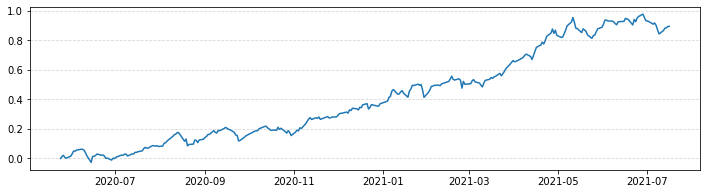

In [5]:
plt.figure(figsize=(12,3))
plt.plot(result['date'], result['cumulative_return'])
plt.grid(axis='y', linestyle='--', alpha=.5)

1.6428907812187967
1.894552054726562


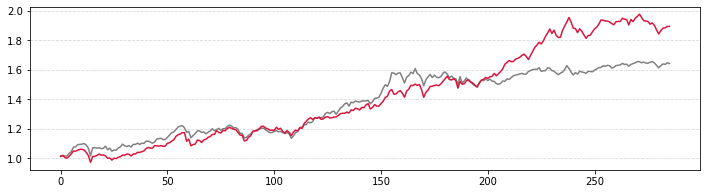

In [13]:
x=1
xs=[]
for k in range(0, len(result['bench_return'].iloc[1:])) :
    x=x*(1+result['bench_return'][k+1])
    xs.append(x)
print(x)

y=1
ys=[]
for k in range(0, len(result['portfolio_return'].iloc[1:])) :
    y=y*(1+result['portfolio_return'][k+1])
    ys.append(y)
print(y)

plt.figure(figsize=(12,3))
plt.plot(xs, c='gray')
plt.plot(ys, c='crimson')
plt.grid(axis='y', linestyle='--', alpha=.5)

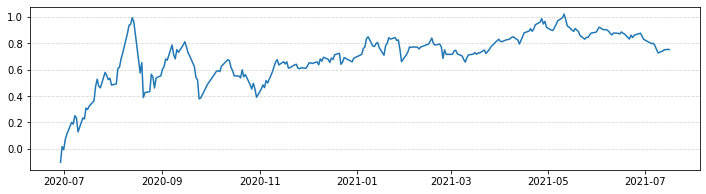

In [6]:
plt.figure(figsize=(12,3))
plt.plot(result['date'].iloc[25:], result['annualized_return'].iloc[25:])
plt.grid(axis='y', linestyle='--', alpha=.5)

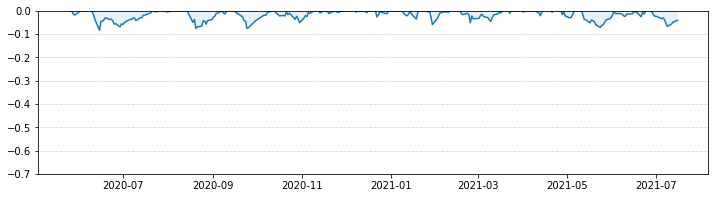

In [10]:
plt.figure(figsize=(12,3))
plt.plot(result['date'], result['drawdown_ratio'])
plt.fill_between(result['date'], result['drawdown_ratio'], result['drawdown_ratio'].max(), alpha=.1)
plt.ylim(-.7,0)
plt.grid(axis='y', linestyle='--', alpha=.5)

total   : 119
2  >  : 32 (0.27)
2  >  > 1.5 : 47 (0.39)
1.5  >  > 1.2 : 31 (0.26)
1.2  >  > 1 : 8 (0.07)


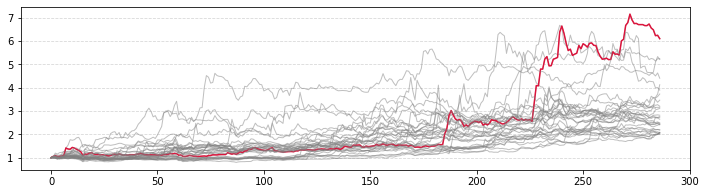

In [103]:
import sklearn
from sklearn.preprocessing import *

p1 = pd.read_csv('C:/Users/ajcltm/Desktop/p1.csv', index_col=0)
tickers = p1.tickers.apply(lambda x: '{:06d}.KS'.format(x))

price_details = {}
for ticker in tickers :
    price_details[ticker] = data[data['symbol']==ticker]['Adj Close'].values.reshape(-1)
    price_details[ticker] = price_details[ticker]/ price_details[ticker][0]
    
price_details_df = pd.DataFrame(data=price_details.values(), index=price_details.keys())
top = price_details_df.sort_values(by=price_details_df.columns[-1], ascending=False).iloc[:1].index.tolist()    

print('total   : {0}'.format(len(tickers)))
plt.figure(figsize=(12,3))
num = 0
thred = 2
for ticker in tickers :
    if price_details[ticker][-1] > thred :
        plt.plot(price_details[ticker], linewidth=1, c='grey', alpha=.5)
        plt.grid(axis='y', linestyle='--', alpha=.5)
        num+=1
    if ticker in top : 
        plt.plot(price_details[ticker], c='crimson', linewidth=1.5, alpha=1)
        plt.grid(axis='y', linestyle='--', alpha=.5)
    

print('{0}  >  : {1} ({2})'.format(thred, num, round(num/len(tickers),2)))

num = 0
thred_upper = 2
thred_down = 1.5
for ticker in tickers :
    if price_details[ticker][-1] > thred_down and price_details[ticker][-1] < thred_upper:
        num+=1
print('{0}  >  > {1} : {2} ({3})'.format(thred_upper, thred_down, num, round(num/len(tickers),2)))

num = 0
thred_upper = 1.5
thred_down = 1.2
for ticker in tickers :
    if price_details[ticker][-1] > thred_down and price_details[ticker][-1] < thred_upper:
        num+=1
print('{0}  >  > {1} : {2} ({3})'.format(thred_upper, thred_down, num, round(num/len(tickers),2)))

num = 0
thred_upper = 1.2
thred_down = 1
for ticker in tickers :
    if price_details[ticker][-1] > thred_down and price_details[ticker][-1] < thred_upper:
        num+=1
print('{0}  >  > {1} : {2} ({3})'.format(thred_upper, thred_down, num, round(num/len(tickers),2)))

In [50]:
result.columns

Index(['date', 'capital_base', 'starting_cash', 'ending_cash',
       'starting_stock_value', 'ending_stock_value',
       'starting_portfolio_value', 'ending_portfolio_value',
       'portfolio_return', 'annualized_return', 'roll_annualized_return',
       'volatility', 'roll_volatility', 'sharp_ratio', 'roll_sharp_ratio',
       'cumulative_return', 'drawdown_ratio', 'MDD', 'underwater_period',
       'win_rate', 'roll_win_rate', 'total_profit', 'alpha', 'beta_kospi_200',
       'bench_return'],
      dtype='object')

In [52]:
pd.set_option('display.float_format', '{:.2f}'.format) 
result[['date','portfolio_return', 'annualized_return', 'roll_annualized_return',
       'volatility', 'roll_volatility', 'sharp_ratio', 'roll_sharp_ratio',
       'cumulative_return']]

,date,portfolio_return,annualized_return,roll_annualized_return,volatility,roll_volatility,sharp_ratio,roll_sharp_ratio,cumulative_return
0,2020-05-25,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00
1,2020-05-26,0.01,4.43,4.43,0.11,0.11,41.28,41.28,0.01
2,2020-05-27,0.01,4.93,4.93,0.09,0.09,56.05,56.05,0.02
3,2020-05-28,-0.02,0.46,0.46,0.17,0.17,2.68,2.68,0.01
4,2020-05-29,-0.00,0.12,0.12,0.16,0.16,0.79,0.79,0.00
5,2020-06-01,0.01,0.89,0.89,0.16,0.16,5.53,5.53,0.02
6,2020-06-02,0.02,2.06,2.06,0.17,0.17,12.40,12.40,0.03
7,2020-06-03,0.02,3.72,3.72,0.17,0.17,21.68,21.68,0.05
8,2020-06-04,-0.00,2.84,2.84,0.17,0.17,17.07,17.07,0.05
9,2020-06-05,0.01,3.04,3.04,0.16,0.16,19.22,19.22,0.06


In [53]:
result[['date', 'drawdown_ratio', 'MDD', 'underwater_period',
       'win_rate', 'roll_win_rate', 'total_profit', 'alpha', 'beta_kospi_200',
       'bench_return']]

,date,drawdown_ratio,MDD,underwater_period,win_rate,roll_win_rate,total_profit,alpha,beta_kospi_200,bench_return
0,2020-05-25,0.00,0,0 days,0.00,0.00,0.00,NaN,NaN,NaN
1,2020-05-26,0.00,0,0 days,0.50,0.50,675910.33,0.01,0.00,0.02
2,2020-05-27,0.00,0,0 days,0.67,0.67,1070831.94,0.01,0.34,0.00
3,2020-05-28,-0.02,-0.02,1 days,0.50,0.50,299933.73,-0.00,1.05,-0.00
4,2020-05-29,-0.02,-0.02,2 days,0.40,0.40,116016.54,-0.00,1.06,0.00
5,2020-06-01,-0.01,-0.02,5 days,0.50,0.50,761020.83,-0.00,1.01,0.02
6,2020-06-02,0.00,-0.02,5 days,0.57,0.57,1578708.32,-0.00,1.09,0.01
7,2020-06-03,0.00,-0.02,5 days,0.62,0.62,2525793.90,-0.00,0.86,0.03
8,2020-06-04,-0.00,-0.02,5 days,0.56,0.56,2459261.13,-0.00,0.87,0.00
9,2020-06-05,0.00,-0.02,5 days,0.60,0.60,2846056.12,-0.00,0.85,0.01


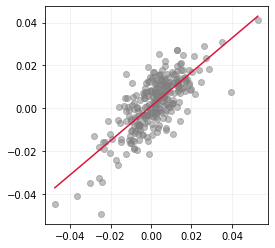

In [55]:
x_max=result['bench_return'].max()
x_min=result['bench_return'].min()
x = np.linspace(x_min, x_max, 100)
y = result['alpha'].values[-1] + result['beta_kospi_200'].values[-1]*x

plt.figure(figsize=(4,4))
plt.scatter(result['bench_return'], result['portfolio_return'],c='gray', alpha=.5)
plt.plot(x,y,c='crimson')
plt.grid(alpha=.2)

In [20]:
result.to_csv('C:/Users/ajcltm/Desktop/backtesting/result.csv')